In [45]:
import os 
import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import catboost as cb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# metrics 
from sklearn.metrics import brier_score_loss, confusion_matrix
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



In [46]:
""" 
NOTE: Right now the data is minmax scaled; However, I will be changing it to standard scaling and compare the performance of the models. 
"""


' \nNOTE: Right now the data is minmax scaled; However, I will be changing it to standard scaling and compare the performance of the models. \n'

In [47]:
""" 
Helper functions 
"""

def custom_brier_score(Y,y):
    return np.mean((Y - y) ** 2)

brier_score_loss = make_scorer(custom_brier_score, greater_is_better=False)

In [48]:
# Load the data 
train_data = pd.read_csv('../data/Recvidism_extra_feat_train.csv')
test_data = pd.read_csv('../data/Recvidism_extra_feat_test.csv')

# length of train and test data  
print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))
print(train_data.columns)

# features and labels 
X_train = train_data.drop(['Recidivism_Within_3years'], axis=1)
X_train = np.ascontiguousarray(X_train)
y_train = train_data['Recidivism_Within_3years']
X_test = test_data.drop(['Recidivism_Within_3years'], axis=1)
y_test = test_data['Recidivism_Within_3years']

Length of train data:  18028
Length of test data:  7807
Index(['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probat

In [49]:
# Split the data into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Pipeline; useful if preprocessing is required 
pipeline = Pipeline(steps=[('model', None)])


In [66]:
# All possible models to run 

# Create a dictionary of classifiers and their hyperparameters
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200,500,800,1000],
            'model__max_depth': [3, 4, 5,6,7],
            'model__learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostClassifier(verbose=0),
        'params': {
            'model__iterations': [100, 200, 300,500, 800],
            'model__learning_rate': [0.01, 0.1, 0.3],
            'model__max_depth': [3, 4, 5,6,7]
        }
    },
    'SVM': { 
        'model': SVC(probability=True),  # Added SVM with probability=True to calculate AUC
        'params': {
            'model__C': np.linspace(0.01,10,100),
            'model__kernel': ['linear', 'rbf']
        }
    },
    
    'KNN': {    
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': np.linspace(5,50,10).astype(int),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    },
    'bayesian_classifier' : {
        "name": "Gaussian Naive Bayes",
        "params": {
            "random_state": 42
        }
}
}

In [51]:

# Train and evaluate classifiers in parallel using Joblib
def train_and_evaluate_classifier(classifier_name, classifier_info):
    print(f"Training {classifier_name}...")
    
    # Create a pipeline with standard scaling and the classifier
    clf = Pipeline([
        ('model', classifier_info['model'])
    ])
    
    # Perform a grid search for hyperparameter tuning
    param_grid = classifier_info['params']

    
    # Use custom scoring functions
    grid_search = GridSearchCV(
        clf, param_grid, cv=5,
        scoring='neg_brier_score',  # Use Brier score as the metric
        refit='AUC',  # Refit using AUC as the best estimator
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)

    # Calculate ROC AUC for the best classifier
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    return {
        'classifier_name': classifier_name,
        'Best Model': grid_search.best_estimator_,
        'Best Parameters': grid_search.best_params_,
        'Brier Score': -grid_search.best_score_,  # Convert back to positive
        'AUC': auc
    }


In [ ]:

# Train and evaluate classifiers in parallel
results = Parallel(n_jobs=10)(
    delayed(train_and_evaluate_classifier)(classifier_name, classifier_info)
    for classifier_name, classifier_info in classifiers.items()
)

# Compare classifier results
for result in results:
    classifier_name = result['classifier_name']
    print(f"\nResults for {classifier_name}:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Brier Score: {result['Brier Score']:.4f}")
    print(f"AUC: {result['AUC']:.4f}\n")

# save all the models 
for result in results:
    classifier_name = result['classifier_name']
    best_classifier = result['Best Model']
    # also save best_params 
    best_params = result['Best Parameters']
    # save the model
    joblib.dump(best_classifier, f'../models/{classifier_name}.pkl')
    # save the best params
    joblib.dump(best_params, f'../models/{classifier_name}_best_params.pkl')
    
    

# Choose the best classifier based on AUC
best_result = max(results, key=lambda x: x['AUC'])
best_classifier_name = best_result['classifier_name']
best_classifier = best_result['Best Model']

# Evaluate the best classifier on the test set
y_pred_prob = best_classifier.predict_proba(X_test)[:, 1]
test_brier_score = custom_brier_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
test_auc = auc(fpr, tpr)


print(f"Best Classifier: {best_classifier_name}")
print(f"Test Brier Score: {test_brier_score:.4f}")
print(f"Test AUC: {test_auc:.4f}")


In [8]:
# Load saved sklearn model 
best_classifier = joblib.load('best_classifier_CatBoost.joblib') 

Test Brier Score: 0.1686


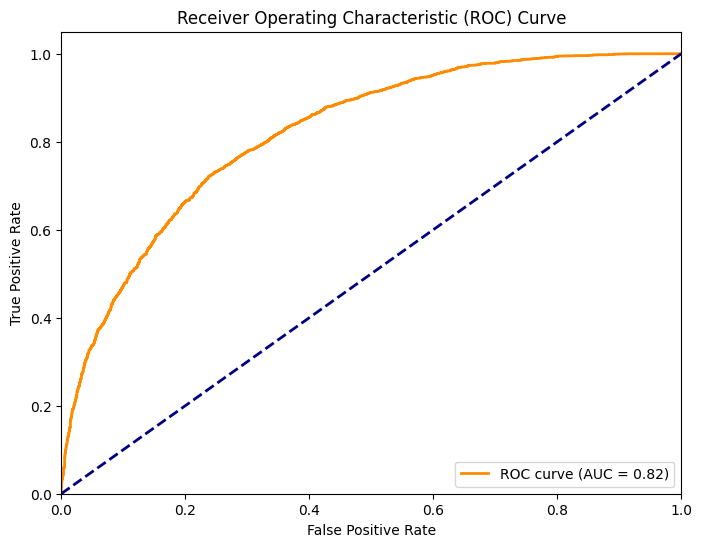

AUC: 0.82


In [31]:

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test)[:,1]

# brier score 
test_brier_score = brier_score_loss(y_test, y_prob)
print(f"Test Brier Score: {test_brier_score:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC: {roc_auc:.2f}')

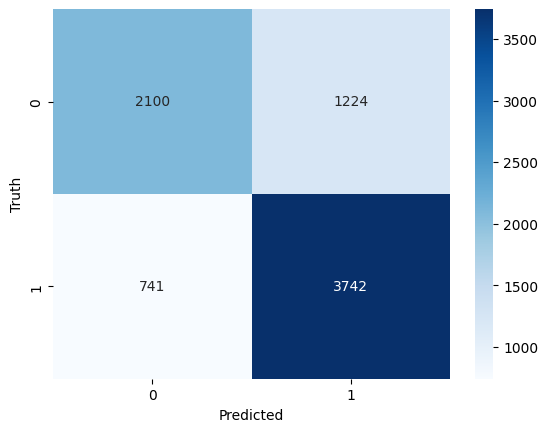

In [33]:
# F1 score 
y_pred = best_classifier.predict(X_test)
f1_score(y_test, y_pred)

# Accuracy score
accuracy_score(y_test, y_pred)

# Precision score
precision_score(y_test, y_pred)

# Recall score
recall_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm
# seanborn heatmap 
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


Total count female:  950
Total count male:  6857
Test Brier Score - Female: 0.1700


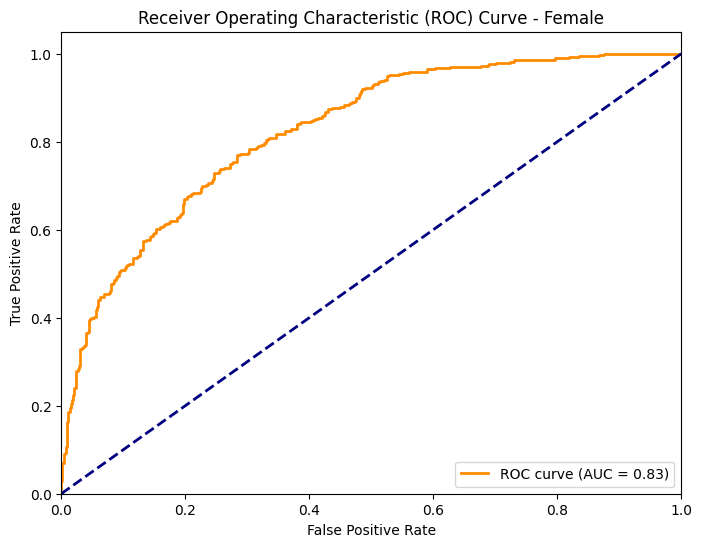

AUC - Female: 0.83
Test Brier Score - male: 0.1684


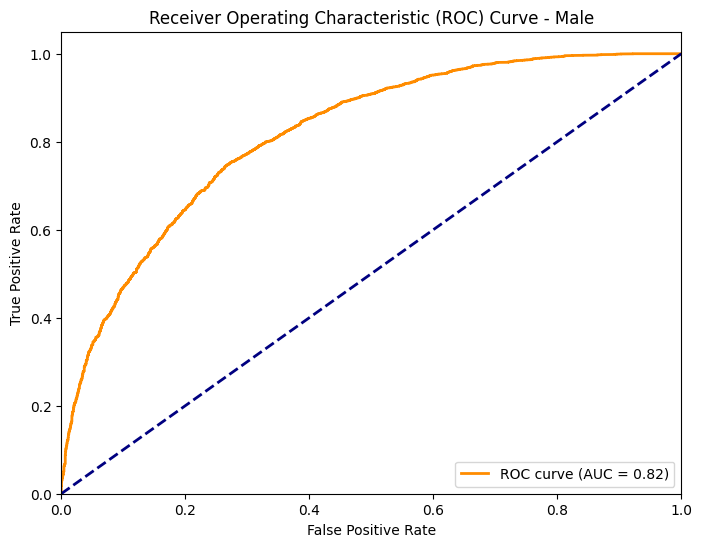

AUC - Male: 0.82


In [36]:
# Male and Female seperate comparison
X_test_female = X_test[X_test['Gender'] ==0 ]
y_test_female = test_data[test_data['Gender']== 0]['Recidivism_Within_3years']
X_test_male = X_test[X_test['Gender'] ==1 ] 
y_test_male = test_data[test_data['Gender']== 1]['Recidivism_Within_3years']


# prediction 
print("Total count female: ", len(y_test_female))
print("Total count male: ", len(y_test_male))

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test_female)[:,1]

# brier score 
test_brier_score_female = brier_score_loss(y_test_female,y_prob)
print(f"Test Brier Score - Female: {test_brier_score_female:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_female, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Female')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC - Female: {roc_auc:.2f}')

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test_male)[:,1]

# brier score 
test_brier_score_male = brier_score_loss(y_test_male,y_prob)
print(f"Test Brier Score - male: {test_brier_score_male:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_male, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Male')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC - Male: {roc_auc:.2f}')


In [37]:
""" 
# Training : 


Results for Logistic Regression:                                                                                     
Best Parameters: {'model__C': 1, 'model__penalty': 'l2'}                                                             
Brier Score: 0.1851                                                                                                  
AUC: 0.7048


Results for Random Forest:
Best Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_est$mators': 200}
Brier Score: 0.1835
AUC: 0.7129


Results for XGBoost:
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}                   
Brier Score: 0.1728
AUC: 0.7298


Results for CatBoost:
Best Parameters: {'model__depth': 5, 'model__iterations': 300, 'model__learning_rate': 0.1}                         
Brier Score: 0.1710
AUC: 0.7332

Best Classifier: CatBoost
Test Brier Score: 0.2517
Test AUC: 0.7332
Best classifier model saved to best_classifier_CatBoost.joblib                                                      
AUC: 0.73

"""

" \nResults for Logistic Regression:                                                                                     \nBest Parameters: {'model__C': 1, 'model__penalty': 'l2'}                                                             \nBrier Score: 0.1851                                                                                                  \nAUC: 0.7048\n\n\nResults for Random Forest:\nBest Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_est$mators': 200}\nBrier Score: 0.1835\nAUC: 0.7129\n\n\nResults for XGBoost:\nBest Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}                   \nBrier Score: 0.1728\nAUC: 0.7298\n\n\nResults for CatBoost:\nBest Parameters: {'model__depth': 5, 'model__iterations': 300, 'model__learning_rate': 0.1}                         \nBrier Score: 0.1710\nAUC: 0.7332\n\nBest Classifier: CatBoost\nTest Brier Score: 0.2517\nTest AUC: 0.7332

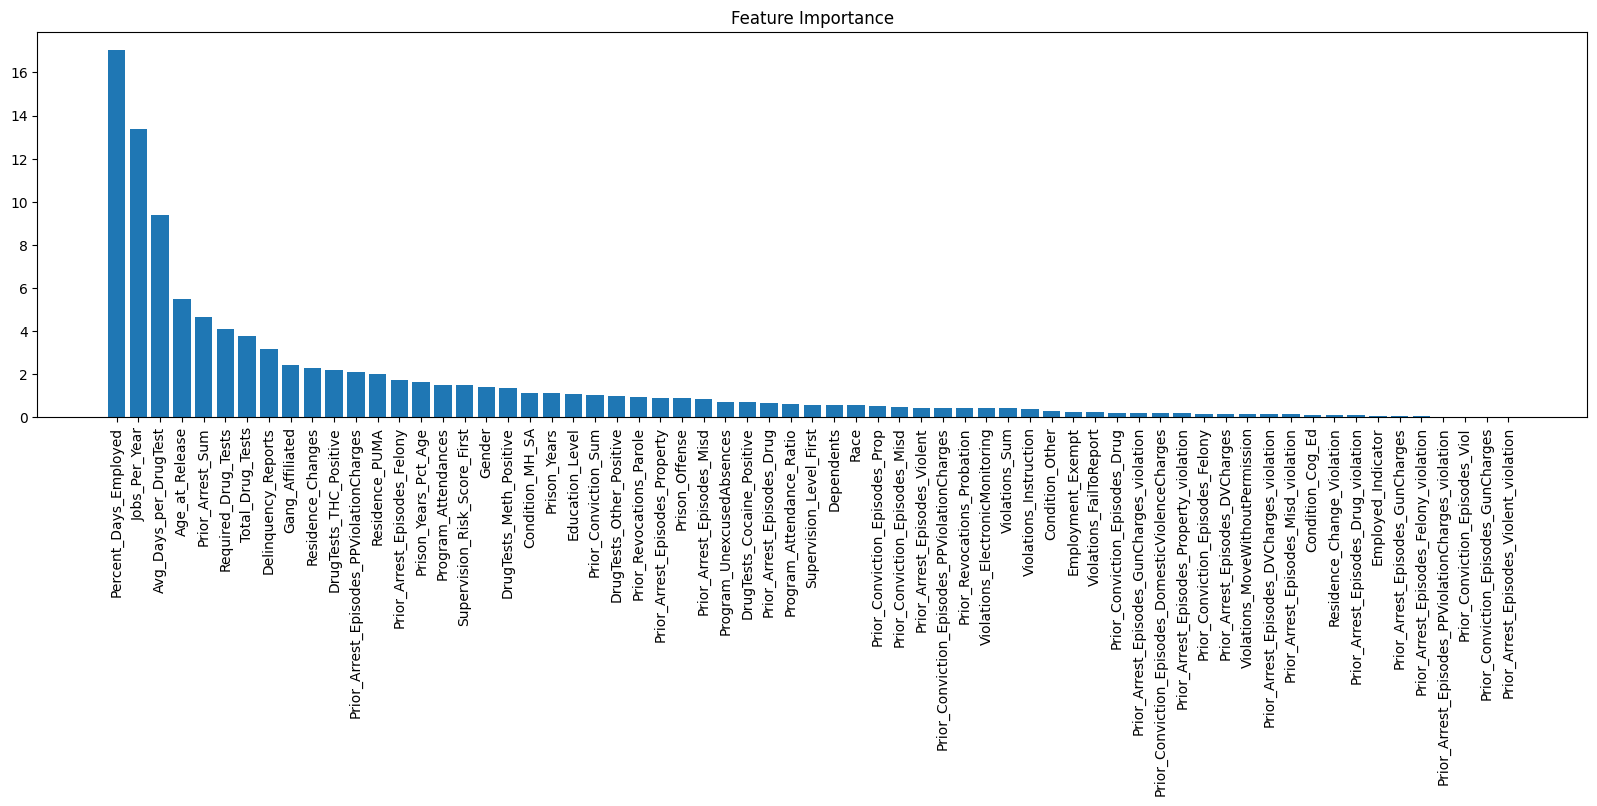

Percent_Days_Employed         : 1703.26%
Jobs_Per_Year                 : 1337.87%
Avg_Days_per_DrugTest         : 936.14%
Age_at_Release                : 549.95%
Prior_Arrest_Sum              : 466.23%
Required_Drug_Tests           : 408.22%
Total_Drug_Tests              : 377.84%
Delinquency_Reports           : 316.74%
Gang_Affiliated               : 239.43%
Residence_Changes             : 227.72%
DrugTests_THC_Positive        : 217.76%
Prior_Arrest_Episodes_PPViolationCharges: 207.54%
Residence_PUMA                : 197.18%
Prior_Arrest_Episodes_Felony  : 173.28%
Prison_Years_Pct_Age          : 161.13%
Program_Attendances           : 149.18%
Supervision_Risk_Score_First  : 149.17%
Gender                        : 138.56%
DrugTests_Meth_Positive       : 133.88%
Condition_MH_SA               : 111.37%
Prison_Years                  : 110.81%
Education_Level               : 108.47%
Prior_Conviction_Sum          : 103.95%
DrugTests_Other_Positive      : 95.76%
Prior_Revocations_Parole     

In [44]:
# for the best classifier; try to check the feature importance 
# Load saved sklearn model
best_classifier = joblib.load('best_classifier_CatBoost.joblib')

# Get feature importances
feature_importances = best_classifier.named_steps['model'].get_feature_importance()

# here the feature importance; i.e. y axis represents the importance of the feature in terms of 

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)


# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")

